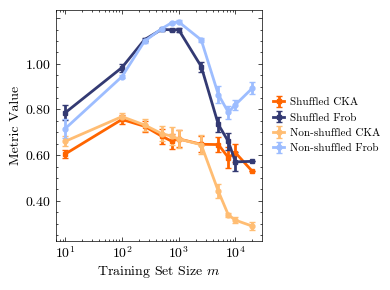

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks"""
        if 0 <= y <= 1:
            return f'${y:.2f}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        # Set log scale for x-axis only
        ax.set_xscale('log')
        ax.minorticks_on()
        
        # Configure x-axis
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        
        # Configure y-axis
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        
        # Set tick parameters
        ax.tick_params(which='both', direction='in')

def load_results(shuffled_paths: List[str], non_shuffled_paths: List[str]) -> Dict:
    """Load results from specific JSON files."""
    all_data = {
        'shuffled': {'n_train': [], 'cka': [], 'frob': []},
        'non_shuffled': {'n_train': [], 'cka': [], 'frob': []}
    }
    
    # Load shuffled data
    for path in shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                all_data['shuffled']['n_train'].append(result['n_train'])
                all_data['shuffled']['cka'].append(result['ntk_cka'])
                all_data['shuffled']['frob'].append(result['ntk_norm_frob'])
    
    # Load non-shuffled data
    for path in non_shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                all_data['non_shuffled']['n_train'].append(result['n_train'])
                all_data['non_shuffled']['cka'].append(result['ntk_cka'])
                all_data['non_shuffled']['frob'].append(result['ntk_norm_frob'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in ['shuffled', 'non_shuffled']:
        n_train_values = sorted(list(set(data[category]['n_train'])))
        cka_means = []
        cka_sems = []
        frob_means = []
        frob_sems = []
        
        for n in n_train_values:
            # Get indices for this n_train value
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            
            # Calculate statistics for CKA
            cka_values = [data[category]['cka'][i] for i in indices]
            cka_means.append(np.mean(cka_values))
            cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
            
            # Calculate statistics for Frobenius norm
            frob_values = [data[category]['frob'][i] for i in indices]
            frob_means.append(np.mean(frob_values))
            frob_sems.append(np.std(frob_values) / np.sqrt(len(frob_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'cka_mean': cka_means,
            'cka_sem': cka_sems,
            'frob_mean': frob_means,
            'frob_sem': frob_sems
        }
    
    return processed

def create_plot(processed_data: Dict):
    """Create combined plot for CKA and Frobenius norm."""
    plotter = SciencePlotter()
    
    # Styles for all four curves
    styles = {
        'shuffled_cka': PlotStyle(
            color="#FF6500",
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label="Shuffled CKA"
        ),
        'shuffled_frob': PlotStyle(
            color="#333A73", 
            linestyle='-', 
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label="Shuffled Frob"
        ),
        'non_shuffled_cka': PlotStyle(
            color="#FFBD73",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="Non-shuffled CKA"
        ),
        'non_shuffled_frob': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="Non-shuffled Frob"
        )
    }
    
    # Create combined plot
    fig, ax = plt.subplots(figsize=(4.0, 3.0))
    
    # Plot data
    for category in ['shuffled', 'non_shuffled']:
        data = processed_data[category]
        
        # Plot CKA
        style = styles[f'{category}_cka']
        ax.errorbar(data['n_train'], data['cka_mean'], 
                   yerr=data['cka_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
        
        # Plot Frobenius norm
        style = styles[f'{category}_frob']
        ax.errorbar(data['n_train'], data['frob_mean'],
                   yerr=data['frob_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'Metric Value', labelpad=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.tight_layout()
    
    return fig

def main():
    # Placeholder paths for JSON files
    shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_true/results_20250118_062757_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_true_2/results_20250119_054416_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_true_3/results_20250119_045336_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_true_4/results_20250119_045336_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_true_5/results_20250119_045344_rank0.json"
    ]
    
    non_shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_false/results_20250118_155726_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_false_2/results_20250119_045219_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_false_3/results_20250119_045303_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_false_4/results_20250119_045214_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/jax_lr0005_false_5/results_20250119_045226_rank0.json"
    ]
    
    # Load and process data
    raw_data = load_results(shuffled_paths, non_shuffled_paths)
    processed_data = process_data(raw_data)
    
    # Create and save plot
    fig = create_plot(processed_data)
    
    fig.savefig('ntk_metrics_comparison.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('ntk_metrics_comparison.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()

if __name__ == "__main__":
    main()

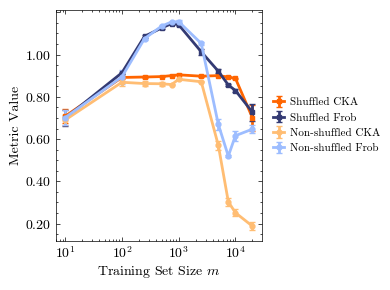

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks"""
        if 0 <= y <= 1:
            return f'${y:.2f}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        ax.set_xscale('log')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        ax.tick_params(which='both', direction='in')

def load_results(shuffled_paths: List[str], non_shuffled_paths: List[str], hidden_size: int) -> Dict:
    """Load results from specific JSON files and filter by hidden_size."""
    all_data = {
        'shuffled': {'n_train': [], 'cka': [], 'frob': []},
        'non_shuffled': {'n_train': [], 'cka': [], 'frob': []}
    }
    
    # Load shuffled data
    for path in shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                # Only include results for the specified hidden size
                if result['hidden_size'] == hidden_size:
                    all_data['shuffled']['n_train'].append(result['n_train'])
                    all_data['shuffled']['cka'].append(result['ntk_cka'])
                    all_data['shuffled']['frob'].append(result['ntk_norm_frob'])
    
    # Load non-shuffled data
    for path in non_shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                # Only include results for the specified hidden size
                if result['hidden_size'] == hidden_size:
                    all_data['non_shuffled']['n_train'].append(result['n_train'])
                    all_data['non_shuffled']['cka'].append(result['ntk_cka'])
                    all_data['non_shuffled']['frob'].append(result['ntk_norm_frob'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in ['shuffled', 'non_shuffled']:
        n_train_values = sorted(list(set(data[category]['n_train'])))
        cka_means = []
        cka_sems = []
        frob_means = []
        frob_sems = []
        
        for n in n_train_values:
            # Get indices for this n_train value
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            
            # Calculate statistics for CKA
            cka_values = [data[category]['cka'][i] for i in indices]
            cka_means.append(np.mean(cka_values))
            cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
            
            # Calculate statistics for Frobenius norm
            frob_values = [data[category]['frob'][i] for i in indices]
            frob_means.append(np.mean(frob_values))
            frob_sems.append(np.std(frob_values) / np.sqrt(len(frob_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'cka_mean': cka_means,
            'cka_sem': cka_sems,
            'frob_mean': frob_means,
            'frob_sem': frob_sems
        }
    
    return processed

def create_plot(processed_data: Dict, hidden_size: int):
    """Create combined plot for CKA and Frobenius norm."""
    plotter = SciencePlotter()
    
    # Styles for all four curves
    styles = {
        'shuffled_cka': PlotStyle(
            color="#FF6500",
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label="Shuffled CKA"
        ),
        'shuffled_frob': PlotStyle(
            color="#333A73", 
            linestyle='-', 
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label="Shuffled Frob"
        ),
        'non_shuffled_cka': PlotStyle(
            color="#FFBD73",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="Non-shuffled CKA"
        ),
        'non_shuffled_frob': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="Non-shuffled Frob"
        )
    }
    
    # Create combined plot
    fig, ax = plt.subplots(figsize=(4.0, 3.0))
    
    # Plot data
    for category in ['shuffled', 'non_shuffled']:
        data = processed_data[category]
        
        # Plot CKA
        style = styles[f'{category}_cka']
        ax.errorbar(data['n_train'], data['cka_mean'], 
                   yerr=data['cka_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
        
        # Plot Frobenius norm
        style = styles[f'{category}_frob']
        ax.errorbar(data['n_train'], data['frob_mean'],
                   yerr=data['frob_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'Metric Value', labelpad=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.tight_layout()
    
    return fig

def main():
    # Set the hidden size here (100 or 400)
    hidden_size = 1000  # Change this value to 400 for the other plot
    
    # Placeholder paths for JSON files
    shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_4/results_20250119_220608_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_5/results_20250119_231254_rank0.json"
    ]
    
    non_shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_4/results_20250119_213507_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_5/results_20250119_223241_rank0.json"
    ]
    
    # Load and process data for specified hidden size
    raw_data = load_results(shuffled_paths, non_shuffled_paths, hidden_size)
    processed_data = process_data(raw_data)
    
    # Create and save plot
    fig = create_plot(processed_data, hidden_size)
    
    # Save with hidden size in filename
    fig.savefig(f'ntk_metrics_comparison_h{hidden_size}.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig(f'ntk_metrics_comparison_h{hidden_size}.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()

if __name__ == "__main__":
    main()

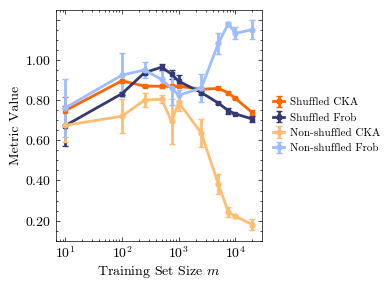

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks"""
        if 0 <= y <= 1:
            return f'${y:.2f}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        ax.set_xscale('log')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        ax.tick_params(which='both', direction='in')

def load_results(shuffled_paths: List[str], non_shuffled_paths: List[str], hidden_size: int) -> Dict:
    """Load results from specific JSON files and filter by hidden_size."""
    all_data = {
        'shuffled': {'n_train': [], 'cka': [], 'frob': []},
        'non_shuffled': {'n_train': [], 'cka': [], 'frob': []}
    }
    
    # Load shuffled data
    for path in shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                # Only include results for the specified hidden size
                if result['hidden_size'] == hidden_size:
                    all_data['shuffled']['n_train'].append(result['n_train'])
                    all_data['shuffled']['cka'].append(result['ntk_cka'])
                    all_data['shuffled']['frob'].append(result['ntk_norm_frob'])
    
    # Load non-shuffled data
    for path in non_shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                # Only include results for the specified hidden size
                if result['hidden_size'] == hidden_size:
                    all_data['non_shuffled']['n_train'].append(result['n_train'])
                    all_data['non_shuffled']['cka'].append(result['ntk_cka'])
                    all_data['non_shuffled']['frob'].append(result['ntk_norm_frob'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in ['shuffled', 'non_shuffled']:
        n_train_values = sorted(list(set(data[category]['n_train'])))
        cka_means = []
        cka_sems = []
        frob_means = []
        frob_sems = []
        
        for n in n_train_values:
            # Get indices for this n_train value
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            
            # Calculate statistics for CKA
            cka_values = [data[category]['cka'][i] for i in indices]
            cka_means.append(np.mean(cka_values))
            cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
            
            # Calculate statistics for Frobenius norm
            frob_values = [data[category]['frob'][i] for i in indices]
            frob_means.append(np.mean(frob_values))
            frob_sems.append(np.std(frob_values) / np.sqrt(len(frob_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'cka_mean': cka_means,
            'cka_sem': cka_sems,
            'frob_mean': frob_means,
            'frob_sem': frob_sems
        }
    
    return processed

def create_plot(processed_data: Dict, hidden_size: int):
    """Create combined plot for CKA and Frobenius norm."""
    plotter = SciencePlotter()
    
    # Styles for all four curves
    styles = {
        'shuffled_cka': PlotStyle(
            color="#FF6500",
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label="Shuffled CKA"
        ),
        'shuffled_frob': PlotStyle(
            color="#333A73", 
            linestyle='-', 
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label="Shuffled Frob"
        ),
        'non_shuffled_cka': PlotStyle(
            color="#FFBD73",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="Non-shuffled CKA"
        ),
        'non_shuffled_frob': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="Non-shuffled Frob"
        )
    }
    
    # Create combined plot
    fig, ax = plt.subplots(figsize=(4.0, 3.0))
    
    # Plot data
    for category in ['shuffled', 'non_shuffled']:
        data = processed_data[category]
        
        # Plot CKA
        style = styles[f'{category}_cka']
        ax.errorbar(data['n_train'], data['cka_mean'], 
                   yerr=data['cka_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
        
        # Plot Frobenius norm
        style = styles[f'{category}_frob']
        ax.errorbar(data['n_train'], data['frob_mean'],
                   yerr=data['frob_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'Metric Value', labelpad=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.tight_layout()
    
    return fig

def main():
    # Set the hidden size here (100 or 400)
    hidden_size = 400  # Change this value to 400 for the other plot
    
    # Placeholder paths for JSON files
    shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_polynn_h1000_lr0005_true_1/results_20250120_043657_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_polynn_h1000_lr0005_true_2/results_20250120_072645_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_polynn_h1000_lr0005_true_3/results_20250120_102854_rank0.json",
    ]
    
    non_shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_polynn_h1000_lr0005_false_1/results_20250120_043211_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_polynn_h1000_lr0005_false_2/results_20250120_071812_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_polynn_h1000_lr0005_false_3/results_20250120_095602_rank0.json",  
    ]
    
    # Load and process data for specified hidden size
    raw_data = load_results(shuffled_paths, non_shuffled_paths, hidden_size)
    processed_data = process_data(raw_data)
    
    # Create and save plot
    fig = create_plot(processed_data, hidden_size)
    
    # Save with hidden size in filename
    fig.savefig(f'ntk_metrics_comparison_h{hidden_size}.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig(f'ntk_metrics_comparison_h{hidden_size}.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
####

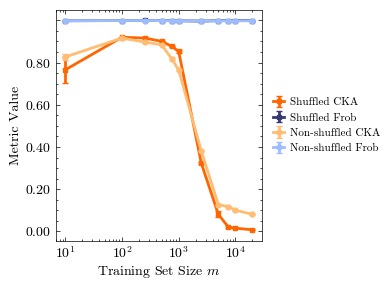

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks"""
        if 0 <= y <= 1:
            return f'${y:.2f}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        ax.set_xscale('log')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        ax.tick_params(which='both', direction='in')

def load_results(shuffled_paths: List[str], non_shuffled_paths: List[str], hidden_size: int) -> Dict:
    """Load results from specific JSON files and filter by hidden_size."""
    all_data = {
        'shuffled': {'n_train': [], 'cka': [], 'frob': []},
        'non_shuffled': {'n_train': [], 'cka': [], 'frob': []}
    }
    
    # Load shuffled data
    for path in shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                # Only include results for the specified hidden size
                if result['hidden_size'] == hidden_size:
                    all_data['shuffled']['n_train'].append(result['n_train'])
                    all_data['shuffled']['cka'].append(result['ntk_cka'])
                    all_data['shuffled']['frob'].append(result['ntk_norm_frob'])
    
    # Load non-shuffled data
    for path in non_shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                # Only include results for the specified hidden size
                if result['hidden_size'] == hidden_size:
                    all_data['non_shuffled']['n_train'].append(result['n_train'])
                    all_data['non_shuffled']['cka'].append(result['ntk_cka'])
                    all_data['non_shuffled']['frob'].append(result['ntk_norm_frob'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in ['shuffled', 'non_shuffled']:
        n_train_values = sorted(list(set(data[category]['n_train'])))
        cka_means = []
        cka_sems = []
        frob_means = []
        frob_sems = []
        
        for n in n_train_values:
            # Get indices for this n_train value
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            
            # Calculate statistics for CKA
            cka_values = [data[category]['cka'][i] for i in indices]
            cka_means.append(np.mean(cka_values))
            cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
            
            # Calculate statistics for Frobenius norm
            frob_values = [data[category]['frob'][i] for i in indices]
            frob_means.append(np.mean(frob_values))
            frob_sems.append(np.std(frob_values) / np.sqrt(len(frob_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'cka_mean': cka_means,
            'cka_sem': cka_sems,
            'frob_mean': frob_means,
            'frob_sem': frob_sems
        }
    
    return processed

def create_plot(processed_data: Dict, hidden_size: int):
    """Create combined plot for CKA and Frobenius norm."""
    plotter = SciencePlotter()
    
    # Styles for all four curves
    styles = {
        'shuffled_cka': PlotStyle(
            color="#FF6500",
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label="Shuffled CKA"
        ),
        'shuffled_frob': PlotStyle(
            color="#333A73", 
            linestyle='-', 
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label="Shuffled Frob"
        ),
        'non_shuffled_cka': PlotStyle(
            color="#FFBD73",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="Non-shuffled CKA"
        ),
        'non_shuffled_frob': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label="Non-shuffled Frob"
        )
    }
    
    # Create combined plot
    fig, ax = plt.subplots(figsize=(4.0, 3.0))
    
    # Plot data
    for category in ['shuffled', 'non_shuffled']:
        data = processed_data[category]
        
        # Plot CKA
        style = styles[f'{category}_cka']
        ax.errorbar(data['n_train'], data['cka_mean'], 
                   yerr=data['cka_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
        
        # Plot Frobenius norm
        style = styles[f'{category}_frob']
        ax.errorbar(data['n_train'], data['frob_mean'],
                   yerr=data['frob_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'Metric Value', labelpad=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.tight_layout()
    
    return fig

def main():
    # Set the hidden size here (100 or 400)
    hidden_size = 1000  # Change this value to 400 for the other plot
    
    # Placeholder paths for JSON files
    shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_1/results_20250120_214844_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_2/results_20250120_230631_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/results_20250121_001615_rank0.json",
    ]
    
    non_shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/results_20250120_214901_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_2/results_20250120_231122_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_3/results_20250121_002630_rank0.json",  
    ]
    
    # Load and process data for specified hidden size
    raw_data = load_results(shuffled_paths, non_shuffled_paths, hidden_size)
    processed_data = process_data(raw_data)
    
    # Create and save plot
    fig = create_plot(processed_data, hidden_size)
    
    # Save with hidden size in filename
    fig.savefig(f'ntk_metrics_comparison_h{hidden_size}.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig(f'ntk_metrics_comparison_h{hidden_size}.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()

if __name__ == "__main__":
    main()

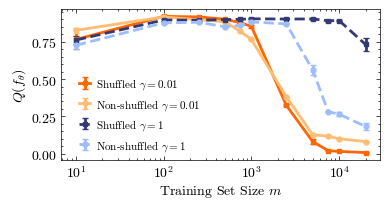

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks"""
        if 0 <= y <= 1:
            return f'${y:.2f}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        ax.set_xscale('log')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        ax.tick_params(which='both', direction='in')

def load_results(paths_dict: Dict[str, List[str]], hidden_size: int) -> Dict:
    """Load results from specific JSON files and filter by hidden_size."""
    all_data = {
        'shuffled_gamma001': {'n_train': [], 'cka': []},
        'non_shuffled_gamma001': {'n_train': [], 'cka': []},
        'shuffled_gamma01': {'n_train': [], 'cka': []},
        'non_shuffled_gamma01': {'n_train': [], 'cka': []}
    }
    
    for category, paths in paths_dict.items():
        for path in paths:
            with open(path, 'r') as f:
                data = json.load(f)
                for result in data:
                    if result['hidden_size'] == hidden_size:
                        all_data[category]['n_train'].append(result['n_train'])
                        all_data[category]['cka'].append(result['ntk_cka'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in data.keys():
        n_train_values = sorted(list(set(data[category]['n_train'])))
        cka_means = []
        cka_sems = []
        
        for n in n_train_values:
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            cka_values = [data[category]['cka'][i] for i in indices]
            cka_means.append(np.mean(cka_values))
            cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'cka_mean': cka_means,
            'cka_sem': cka_sems
        }
    
    return processed

def create_plot(processed_data: Dict, hidden_size: int):
    """Create plot for CKA with different gamma values."""
    plotter = SciencePlotter()
    
    # Styles for all curves (keeping original colors)
    styles = {
        'shuffled_gamma001': PlotStyle(
            color="#FF6500",
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label=r"Shuffled $\gamma=0.01$"
        ),
        'non_shuffled_gamma001': PlotStyle(
            color="#FFBD73",
            linestyle='-',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label=r"Non-shuffled $\gamma=0.01$"
        ),
        'shuffled_gamma01': PlotStyle(
            color="#333A73",
            linestyle='--',
            linewidth=2.0,
            marker='s',
            markersize=3.0,
            label=r"Shuffled $\gamma=1$"
        ),
        'non_shuffled_gamma01': PlotStyle(
            color="#9DBDFF",
            linestyle='--',
            linewidth=2.0,
            marker='o',
            markersize=3.5,
            label=r"Non-shuffled $\gamma=1$"
        )
    }
    
    # Create plot
    fig, ax = plt.subplots(figsize=(4.0, 2.2))
    
    # Plot data
    for category, style in styles.items():
        data = processed_data[category]
        ax.errorbar(data['n_train'], data['cka_mean'], 
                   yerr=data['cka_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'$Q(f_{\mathbf{\theta}})$', labelpad=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(0.02, 0.3), fontsize=8)
    plt.tight_layout()
    
    return fig

def main():
    # Set the hidden size
    hidden_size = 1000
    
    # Paths for different configurations
    paths_dict = {
        'shuffled_gamma001': [
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_1/results_20250120_214844_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_2/results_20250120_230631_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/results_20250121_001615_rank0.json",
        ],
        'non_shuffled_gamma001': [
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/results_20250120_214901_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_2/results_20250120_231122_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_3/results_20250121_002630_rank0.json",
        ],
        # Add your new gamma=0.1 paths here
        'shuffled_gamma01': [
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json"
        ],
        'non_shuffled_gamma01': [
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json"
        ]
    }
    
    # Load and process data
    raw_data = load_results(paths_dict, hidden_size)
    processed_data = process_data(raw_data)
    
    # Create and save plot
    fig = create_plot(processed_data, hidden_size)
    
    # Save plot
    fig.savefig(f'ntk_cka_comparison_h{hidden_size}.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig(f'ntk_cka_comparison_h{hidden_size}.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
  shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_4/results_20250119_220608_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_5/results_20250119_231254_rank0.json"
    ]
    
    non_shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_4/results_20250119_213507_rank0.json",
        "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_5/results_20250119_223241_rank0.json"

KeyError: 'shuffled_gamma1'

/tmp/ipykernel_4166990/3378879504.py:215: UserWarning: Glyph 947 (\N{GREEK SMALL LETTER GAMMA}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_4166990/3378879504.py:255: UserWarning: Glyph 947 (\N{GREEK SMALL LETTER GAMMA}) missing from font(s) cmr10.
  fig.savefig(f'ntk_test_errors_comparison_h{hidden_size}.png',
/tmp/ipykernel_4166990/3378879504.py:261: UserWarning: Glyph 947 (\N{GREEK SMALL LETTER GAMMA}) missing from font(s) cmr10.
  fig.savefig(f'ntk_test_errors_comparison_h{hidden_size}.svg',
/mnt/users/goringn/NNs_vs_Kernels/env_dev_1/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 947 (\N{GREEK SMALL LETTER GAMMA}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


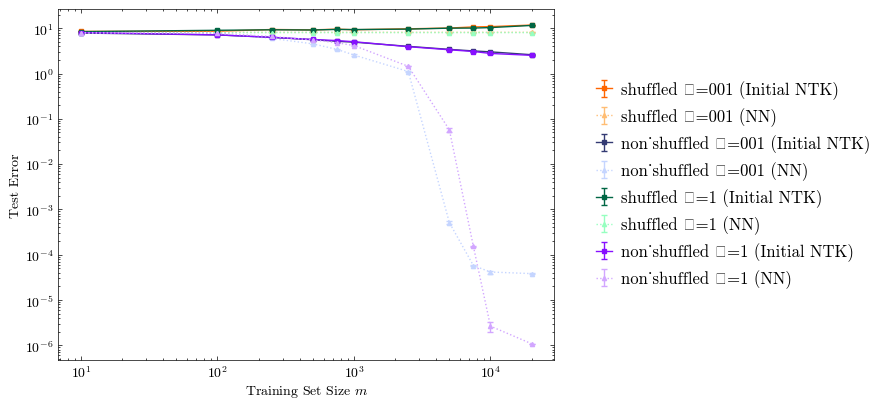

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (4.0, 2.2),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        return f'${y:.2f}$'

    def configure_axes(self, ax):
        ax.set_xscale('log')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        ax.tick_params(which='both', direction='in')

def load_results(paths_dict: Dict[str, List[str]], hidden_size: int) -> Dict:
    all_data = {
        'shuffled_gamma001': {'n_train': [], 'init_ntk': [], 'final_ntk': [], 'test': []},
        'non_shuffled_gamma001': {'n_train': [], 'init_ntk': [], 'final_ntk': [], 'test': []},
        'shuffled_gamma1': {'n_train': [], 'init_ntk': [], 'final_ntk': [], 'test': []},
        'non_shuffled_gamma1': {'n_train': [], 'init_ntk': [], 'final_ntk': [], 'test': []}
    }
    
    for category, paths in paths_dict.items():
        for path in paths:
            with open(path, 'r') as f:
                data = json.load(f)
                for result in data:
                    if result['hidden_size'] == hidden_size:
                        all_data[category]['n_train'].append(result['n_train'])
                        all_data[category]['init_ntk'].append(result['init_ntk_test_error'])
                        all_data[category]['final_ntk'].append(result['final_ntk_test_error'])
                        all_data[category]['test'].append(result['test_error'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    processed = {}
    
    for category in data.keys():
        n_train_values = sorted(list(set(data[category]['n_train'])))
        init_ntk_means = []
        init_ntk_sems = []
        final_ntk_means = []
        final_ntk_sems = []
        test_means = []
        test_sems = []
        
        for n in n_train_values:
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            
            init_ntk_values = [data[category]['init_ntk'][i] for i in indices]
            final_ntk_values = [data[category]['final_ntk'][i] for i in indices]
            test_values = [data[category]['test'][i] for i in indices]
            
            init_ntk_means.append(np.mean(init_ntk_values))
            init_ntk_sems.append(np.std(init_ntk_values) / np.sqrt(len(init_ntk_values)))
            
            final_ntk_means.append(np.mean(final_ntk_values))
            final_ntk_sems.append(np.std(final_ntk_values) / np.sqrt(len(final_ntk_values)))
            
            test_means.append(np.mean(test_values))
            test_sems.append(np.std(test_values) / np.sqrt(len(test_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'init_ntk_mean': init_ntk_means,
            'init_ntk_sem': init_ntk_sems,
            'final_ntk_mean': final_ntk_means,
            'final_ntk_sem': final_ntk_sems,
            'test_mean': test_means,
            'test_sem': test_sems
        }
    
    return processed

def create_plot(processed_data: Dict, hidden_size: int):
    plotter = SciencePlotter()
    
    # Colors for different gammas and shuffled/non-shuffled
    colors = {
        'shuffled_gamma001': {
            'init': "#FF6500",  # Orange
            'final': "#FFB463", # Light Orange
            'test': "#FFBD73"   # Very Light Orange
        },
        'non_shuffled_gamma001': {
            'init': "#333A73",  # Navy Blue
            'final': "#9DBDFF", # Light Blue
            'test': "#C5D5FF"   # Very Light Blue
        },
        'shuffled_gamma1': {
            'init': "#006644",  # Dark Green
            'final': "#30B685", # Medium Green
            'test': "#96FFC0"   # Light Green
        },
        'non_shuffled_gamma1': {
            'init': "#8710FF",  # Purple
            'final': "#B469FF", # Medium Purple
            'test': "#D2A6FF"   # Light Purple
        }
    }
    
    # Create plot
    fig, ax = plt.subplots(figsize=(9.0, 4.2))
    
    # Plot data for each category
    for category in processed_data.keys():
        data = processed_data[category]
        category_colors = colors[category]
        
        # Plot initial NTK error
        ax.errorbar(data['n_train'], data['init_ntk_mean'], 
                   yerr=data['init_ntk_sem'],
                   color=category_colors['init'],
                   linestyle='-',
                   linewidth=1.0,
                   marker='s',
                   markersize=3.0,
                   label=f"{category.replace('_gamma', ' γ=')} (Initial NTK)",
                   capsize=2)
        
        # Plot final NTK error
        # ax.errorbar(data['n_train'], data['final_ntk_mean'], 
        #            yerr=data['final_ntk_sem'],
        #            color=category_colors['final'],
        #            linestyle='--',
        #            linewidth=1.0,
        #            marker='o',
        #            markersize=3.0,
        #            label=f"{category.replace('_gamma', ' γ=')} (Final NTK)",
        #            capsize=2)
        
        # Plot test error
        ax.errorbar(data['n_train'], data['test_mean'], 
                   yerr=data['test_sem'],
                   color=category_colors['test'],
                   linestyle=':',
                   linewidth=1.0,
                   marker='^',
                   markersize=3.0,
                   label=f"{category.replace('_gamma', ' γ=')} (NN)",
                   capsize=2)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'Test Error', labelpad=2)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=12)
    ax.set_yscale('log')
    plt.tight_layout()
    
    return fig

def main():
    # Set the hidden size
    hidden_size = 1000
    
    # Paths for different configurations
    paths_dict = {
        'shuffled_gamma001': [
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_1/results_20250120_214844_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_2/results_20250120_230631_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/results_20250121_001615_rank0.json",
        ],
        'non_shuffled_gamma001': [
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/results_20250120_214901_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_2/results_20250120_231122_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_3/results_20250121_002630_rank0.json",
        ],
        'shuffled_gamma1': [
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json"
        ],
        'non_shuffled_gamma1': [
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
            "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json"
        ]
    }
    
    # Load and process data
    raw_data = load_results(paths_dict, hidden_size)
    processed_data = process_data(raw_data)
    
    # Create and save plot
    fig = create_plot(processed_data, hidden_size)
    
    # Save plot
    fig.savefig(f'ntk_test_errors_comparison_h{hidden_size}.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig(f'ntk_test_errors_comparison_h{hidden_size}.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
#### final fig

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


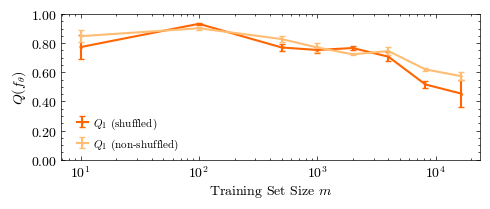

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (2.8, 3.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks"""
        if 0 <= y <= 1:
            return f'${y:.2f}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        # Set log scale for x-axis only
        ax.set_xscale('log')
        ax.minorticks_on()
        
        # Configure x-axis
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        
        # Configure y-axis
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        
        # Set tick parameters
        ax.tick_params(which='both', direction='in')

def load_results(shuffled_paths: List[str], non_shuffled_paths: List[str]) -> Dict:
    """Load results from specific JSON files."""
    all_data = {
        'shuffled': {'n_train': [], 'cka': [], 'frob': []},
        'non_shuffled': {'n_train': [], 'cka': [], 'frob': []}
    }
    
    # Load shuffled data
    for path in shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                all_data['shuffled']['n_train'].append(result['n_train'])
                all_data['shuffled']['cka'].append(result['ntk_cka_init_vs_final'])
                all_data['shuffled']['frob'].append(result['ntk_frob_init_vs_final'])
    
    # Load non-shuffled data
    for path in non_shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                all_data['non_shuffled']['n_train'].append(result['n_train'])
                all_data['non_shuffled']['cka'].append(result['ntk_cka_init_vs_final'])
                all_data['non_shuffled']['frob'].append(result['ntk_frob_init_vs_final'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in ['shuffled', 'non_shuffled']:
        n_train_values = sorted(list(set(data[category]['n_train'])))
        cka_means = []
        cka_sems = []
        frob_means = []
        frob_sems = []
        
        for n in n_train_values:
            # Get indices for this n_train value
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            
            # Calculate statistics for CKA
            cka_values = [data[category]['cka'][i] for i in indices]
            cka_means.append(np.mean(cka_values))
            cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
            print(len(cka_values))
            # Calculate statistics for Frobenius norm
            frob_values = [data[category]['frob'][i] for i in indices]
            frob_means.append(np.mean(frob_values))
            frob_sems.append(np.std(frob_values) / np.sqrt(len(frob_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'cka_mean': cka_means,
            'cka_sem': cka_sems,
            'frob_mean': frob_means,
            'frob_sem': frob_sems
        }
    
    return processed

def create_plot(processed_data: Dict):
    """Create combined plot for CKA and Frobenius norm."""
    plotter = SciencePlotter()
    
    # Styles for all four curves
    styles = {
        'shuffled_cka': PlotStyle(
            color="#FF6500",
            linestyle='-',
            linewidth=1.5,
            marker='s',
            markersize=1.0,
            label=r"$Q_1$ (shuffled)"
        ),
        'shuffled_frob': PlotStyle(
            color="#333A73", 
            linestyle='-', 
            linewidth=1.5,
            marker='s',
            markersize=1.0,
            label=r"$Q_2$ (shuffled)"
        ),
        'non_shuffled_cka': PlotStyle(
            color="#FFBD73",
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=1.0,
            label=r"$Q_1$ (non-shuffled)"
        ),
        'non_shuffled_frob': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=1.0,
            label=r"$Q_2$ (non-shuffled)"
        )
    }
    
    # Create combined plot
    fig, ax = plt.subplots(figsize=(5.0, 2.2))
    
    # Plot data
    for category in ['shuffled', 'non_shuffled']:
        data = processed_data[category]
        
        # Plot CKA
        style = styles[f'{category}_cka']
        ax.errorbar(data['n_train'], data['cka_mean'], 
                   yerr=data['cka_sem'],
                   color=style.color,
                   linestyle=style.linestyle,
                   linewidth=style.linewidth,
                   marker=style.marker,
                   markersize=style.markersize,
                   label=style.label,
                   capsize=2)
        
        # Plot Frobenius norm
        style = styles[f'{category}_frob']
        #ax.errorbar(data['n_train'], data['frob_mean'],
        #           yerr=data['frob_sem'],
        #           color=style.color,
        #           linestyle=style.linestyle,
        #           linewidth=style.linewidth,
        #           marker=style.marker,
        #           markersize=style.markersize,
        #           label=style.label,
        #           capsize=2)
    
    plotter.configure_axes(ax)
    ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax.set_ylabel(r'$Q(f_{\theta})$', labelpad=2)
    ax.set_ylim(0, 1)
    ax.legend(frameon=False, loc='center left', bbox_to_anchor=(0.01, 0.18), fontsize=8)
    plt.tight_layout()
    
    return fig

def main():
    # Placeholder paths for JSON files
    shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_1.json",
        "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_2.json",
        "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_3.json"
        
    ]
    
    non_shuffled_paths = [
        "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle1.json",
        "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle2.json",
        "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle_3.json"
    ]
    
    # Load and process data
    raw_data = load_results(shuffled_paths, non_shuffled_paths)
    processed_data = process_data(raw_data)
    
    # Create and save plot
    fig = create_plot(processed_data)
    
    fig.savefig('ntk_metrics_comparison.png', 
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('ntk_metrics_comparison.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    plt.show()

if __name__ == "__main__":
    main()

Loading gamma comparison data...
Loading metrics comparison data...


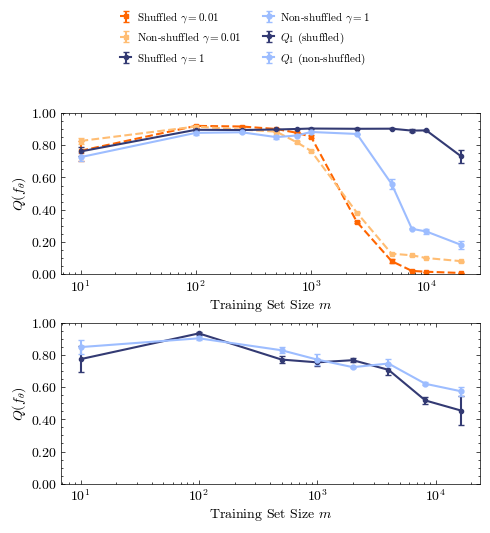

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (5.0, 5.0),  # Adjusted for two subplots
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def format_x_ticks(self, x, pos):
        """Format x-axis ticks in scientific notation"""
        if x == 0:
            return '0'
        exponent = int(np.log10(x))
        if abs(x - 10**exponent) < 1e-10:
            return f'$10^{{{exponent}}}$'
        return ''

    def format_y_ticks(self, y, pos):
        """Format y-axis ticks"""
        if 0 <= y <= 1:
            return f'${y:.2f}$'
        return ''

    def configure_axes(self, ax):
        """Configure axes with different formatting for x and y axes"""
        ax.set_xscale('log')
        ax.minorticks_on()
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_x_ticks))
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10)))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.format_y_ticks))
        ax.tick_params(which='both', direction='in')
        ax.set_ylim(0, 1)


def load_results(paths_dict: Dict[str, List[str]], hidden_size: int) -> Dict:
    """Load results from JSON files with different possible structures."""
    all_data = {category: {'n_train': [], 'cka': [], 'frob': []} for category in paths_dict.keys()}
    
    for category, paths in paths_dict.items():
        for path in paths:
            try:
                with open(path, 'r') as f:
                    data = json.load(f)
                    for result in data:
                        if result.get('hidden_size', hidden_size) == hidden_size:
                            # Common field
                            all_data[category]['n_train'].append(result['n_train'])
                            
                            # Handle CKA based on available fields
                            if 'ntk_cka' in result:
                                all_data[category]['cka'].append(result['ntk_cka'])
                                all_data[category]['frob'].append(result['ntk_norm_frob'])
                            elif 'ntk_cka_init_vs_final' in result:
                                all_data[category]['cka'].append(result['ntk_cka_init_vs_final'])
                                all_data[category]['frob'].append(result['ntk_frob_init_vs_final'])
                            else:
                                print(f"Warning: Neither ntk_cka nor ntk_cka_init_vs_final found in file {path}")
                                print(f"Available keys: {list(result.keys())}")
                                raise KeyError("Required CKA field not found")
            except Exception as e:
                print(f"Error processing file {path}: {str(e)}")
                print(f"Keys in result: {list(result.keys()) if 'result' in locals() else 'No result available'}")
                raise
    
    return all_data

def load_results_metrics(shuffled_paths: List[str], non_shuffled_paths: List[str]) -> Dict:
    """Load results from metrics comparison JSON files."""
    all_data = {
        'shuffled': {'n_train': [], 'cka': [], 'frob': []},
        'non_shuffled': {'n_train': [], 'cka': [], 'frob': []}
    }
    
    def process_file(path, category):
        try:
            with open(path, 'r') as f:
                data = json.load(f)
                for result in data:
                    all_data[category]['n_train'].append(result['n_train'])
                    all_data[category]['cka'].append(result['ntk_cka_init_vs_final'])
                    all_data[category]['frob'].append(result['ntk_frob_init_vs_final'])
        except Exception as e:
            print(f"Error processing file {path}: {str(e)}")
            print(f"Keys in result: {list(result.keys()) if 'result' in locals() else 'No result available'}")
            raise
    
    for path in shuffled_paths:
        process_file(path, 'shuffled')
    
    for path in non_shuffled_paths:
        process_file(path, 'non_shuffled')
    
    return all_data


def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in data.keys():
        n_train_values = sorted(list(set(data[category]['n_train'])))
        cka_means = []
        cka_sems = []
        
        for n in n_train_values:
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            cka_values = [data[category]['cka'][i] for i in indices]
            cka_means.append(np.mean(cka_values))
            cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'cka_mean': cka_means,  # Changed from error_mean to cka_mean
            'cka_sem': cka_sems     # Changed from error_sem to cka_sem
        }
    
    return processed

def process_data_metrics(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value for metrics comparison."""
    processed = {}
    
    for category in ['shuffled', 'non_shuffled']:
        n_train_values = sorted(list(set(data[category]['n_train'])))
        cka_means = []
        cka_sems = []
        
        for n in n_train_values:
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            
            # Calculate statistics for CKA
            cka_values = [data[category]['cka'][i] for i in indices]
            cka_means.append(np.mean(cka_values))
            cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'cka_mean': cka_means,
            'cka_sem': cka_sems
        }
    
    return processed



def create_combined_plot(processed_data1, processed_data2):
    """Create combined plot with two subplots and shared legend."""
    plotter = SciencePlotter()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.0, 5.0), height_ratios=[1, 1])
    
    # Styles for top plot (gamma comparison)
    styles1 = {
        'shuffled_gamma001': PlotStyle(
            color="#FF6500",
            linestyle='--',
            linewidth=1.5,
            marker='s',
            markersize=3.0,
            label=r"Shuffled $\gamma=0.01$"
        ),
        'non_shuffled_gamma001': PlotStyle(
            color="#FFBD73",
            linestyle='--',
            linewidth=1.5,
            marker='s',
            markersize=3.5,
            label=r"Non-shuffled $\gamma=0.01$"
        ),
        'shuffled_gamma01': PlotStyle(
            color="#333A73",
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=3.0,
            label=r"Shuffled $\gamma=1$"
        ),
        'non_shuffled_gamma01': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=3.5,
            label=r"Non-shuffled $\gamma=1$"
        )
    }
    
    # Styles for bottom plot (metrics comparison)
    styles2 = {
        'shuffled_cka': PlotStyle(
            color="#333A73",
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=3.0,
            label=r"$Q_1$ (shuffled)"
        ),
        'non_shuffled_cka': PlotStyle(
            color="#9DBDFF", 
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=3.5,
            label=r"$Q_1$ (non-shuffled)"
        ),
        'shuffled_frob': PlotStyle(
            color="#FF6500",
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=3.0,
            label=r"$Q_2$ (shuffled)"
        ),
        'non_shuffled_frob': PlotStyle(
            color="#FFBD73",
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=3.5,
            label=r"$Q_2$ (non-shuffled)"
        )
    }
    
    # Plot top subplot (gamma comparison)
    for category, style in styles1.items():
        data = processed_data1[category]
        ax1.errorbar(data['n_train'], data['cka_mean'],
                    yerr=data['cka_sem'],
                    color=style.color,
                    linestyle=style.linestyle,
                    linewidth=style.linewidth,
                    marker=style.marker,
                    markersize=style.markersize,
                    label=style.label,
                    capsize=2)
    
    # Plot bottom subplot (metrics comparison)
    for category in ['shuffled', 'non_shuffled']:
        data = processed_data2[category]
        # Plot CKA
        style = styles2[f'{category}_cka']
        ax2.errorbar(data['n_train'], data['cka_mean'],
                    yerr=data['cka_sem'],
                    color=style.color,
                    linestyle=style.linestyle,
                    linewidth=style.linewidth,
                    marker=style.marker,
                    markersize=style.markersize,
                    label=style.label,
                    capsize=2)
    
    # Configure both axes
    for ax in [ax1, ax2]:
        plotter.configure_axes(ax)
        ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
        ax.set_ylabel(r'$Q(f_{\mathbf{\theta}})$', labelpad=2)
    
    # Create common legend above the plots
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1 + handles2, labels1 + labels2,
              loc='center', bbox_to_anchor=(0.5, 1.0),
              ncol=2, fontsize=8, frameon=False)
    
    # Adjust layout
    plt.tight_layout()
    # Adjust subplot spacing and make room for legend
    plt.subplots_adjust(top=0.85, hspace=0.3)
    
    return fig



def main():
    try:
        # Data loading for first plot (gamma comparison)
        hidden_size = 1000
        paths_dict = {
            'shuffled_gamma001': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_1/results_20250120_214844_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_2/results_20250120_230631_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/results_20250121_001615_rank0.json",
            ],
            'non_shuffled_gamma001': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/results_20250120_214901_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_2/results_20250120_231122_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_3/results_20250121_002630_rank0.json",
            ],
            'shuffled_gamma01': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json"
            ],
            'non_shuffled_gamma01': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json"
            ]
        }
        
        # Process data for first plot
        print("Loading gamma comparison data...")
        raw_data1 = load_results(paths_dict, hidden_size)
        processed_data1 = process_data(raw_data1)
    
        # Data loading for second plot (metrics comparison)
        shuffled_paths = [
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_1.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_2.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_3.json"
        ]
    
        non_shuffled_paths = [
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle1.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle2.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle_3.json"
        ]
        
        # Process data for second plot
        print("Loading metrics comparison data...")
        raw_data2 = load_results_metrics(shuffled_paths, non_shuffled_paths)
        processed_data2 = process_data_metrics(raw_data2)
        
        # Create combined plot
        fig = create_combined_plot(processed_data1, processed_data2)
        
        # Save combined plot
        fig.savefig('combined_comparison.png',
                    dpi=300,
                    bbox_inches='tight',
                    facecolor='white',
                    edgecolor='black')
        
        fig.savefig('combined_comparison.svg',
                    bbox_inches='tight',
                    facecolor='white',
                    edgecolor='black')
        
        plt.show()
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file: {e.filename}")
        print("Please check if the file paths are correct")
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise  # Re-raise the exception to see full traceback

if __name__ == "__main__":
    main()

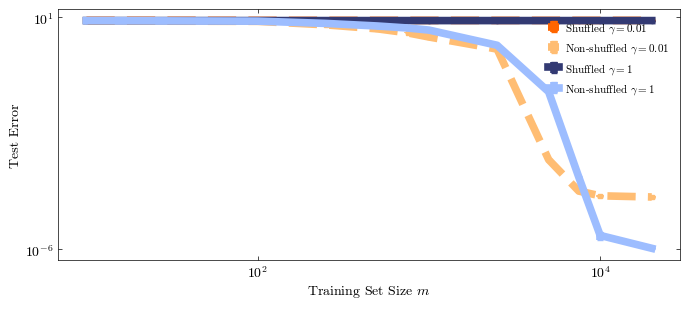

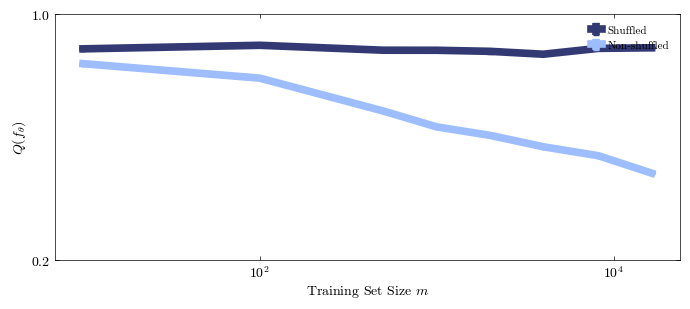

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from dataclasses import dataclass
from typing import Optional, List, Dict
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (5.0, 5.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_axes(self, ax, plot_type='gamma'):
        """Configure axes with exactly two ticks on each axis"""
        ax.set_xscale('log')
        
        # Set two x-ticks at powers of 10
        x_ticks = np.array([10**2, 10**4])
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'$10^{int(np.log10(x))}$' for x in x_ticks])
        
        if plot_type == 'gamma':
            # First plot: log scale from 10^-6 to 10^0
            ax.set_yscale('log')
            y_ticks = np.array([1e-6, 10])
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(['$10^{-6}$', '$10^{1}$'])
            #ax.set_ylim(1e-6, 1e0)
        else:
            # Second plot: linear scale from 0.2 to 1.0
            ax.set_yscale('linear')
            y_ticks = np.array([0.2, 1.0])
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(['$0.2$', '$1.0$'])
            ax.set_ylim(0.2, 1.0)
        
        # Remove minor ticks
        ax.minorticks_off()
        
        # Keep the tick parameters
        ax.tick_params(which='major', direction='in')

def load_results_gamma(paths_dict: Dict[str, List[str]], hidden_size: int) -> Dict:
    """Load results from gamma comparison JSON files."""
    all_data = {category: {'n_train': [], 'test_error': []} for category in paths_dict.keys()}
    
    for category, paths in paths_dict.items():
        for path in paths:
            with open(path, 'r') as f:
                data = json.load(f)
                for result in data:
                    if result.get('hidden_size', hidden_size) == hidden_size:
                        all_data[category]['n_train'].append(result['n_train'])
                        all_data[category]['test_error'].append(result['test_error'])
    
    return all_data

def load_results_shuffle(shuffled_paths: List[str], non_shuffled_paths: List[str]) -> Dict:
    """Load results from shuffle comparison JSON files."""
    all_data = {
        'shuffled': {'n_train': [], 'test_error': []},
        'non_shuffled': {'n_train': [], 'test_error': []}
    }
    
    for path in shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                all_data['shuffled']['n_train'].append(result['n_train'])
                all_data['shuffled']['test_error'].append(1.0 - result['best_test_accuracy'])
    
    for path in non_shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                all_data['non_shuffled']['n_train'].append(result['n_train'])
                all_data['non_shuffled']['test_error'].append(1.0 - result['best_test_accuracy'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in data.keys():
        n_train_values = sorted(list(set(data[category]['n_train'])))
        error_means = []
        error_sems = []
        
        for n in n_train_values:
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            error_values = [data[category]['test_error'][i] for i in indices]
            error_means.append(np.mean(error_values))
            error_sems.append(np.std(error_values) / np.sqrt(len(error_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'error_mean': error_means,
            'error_sem': error_sems
        }
    
    return processed

def create_separate_plots(processed_data_gamma, processed_data_shuffle):
    """Create two separate plots with specified y-scales"""
    plotter = SciencePlotter()
    
    # Create figures
    fig1, ax1 = plt.subplots(figsize=(7.0, 3.2))
    fig2, ax2 = plt.subplots(figsize=(7.0, 3.2))
    
    # Styles for plots
    styles_gamma = {
        'shuffled_gamma001': PlotStyle(
            color="#FF6500",
            linestyle='--',
            linewidth=5.5,
            marker='s',
            markersize=3.0,
            label=r"Shuffled $\gamma=0.01$"
        ),
        'non_shuffled_gamma001': PlotStyle(
            color="#FFBD73",
            linestyle='--',
            linewidth=5.5,
            marker='s',
            markersize=3.5,
            label=r"Non-shuffled $\gamma=0.01$"
        ),
        'shuffled_gamma01': PlotStyle(
            color="#333A73",
            linestyle='-',
            linewidth=5.5,
            marker='o',
            markersize=3.0,
            label=r"Shuffled $\gamma=1$"
        ),
        'non_shuffled_gamma01': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=5.5,
            marker='o',
            markersize=3.5,
            label=r"Non-shuffled $\gamma=1$"
        )
    }
    
    styles_shuffle = {
        'shuffled': PlotStyle(
            color="#333A73",
            linestyle='-',
            linewidth=5.5,
            marker='o',
            markersize=3.0,
            label="Shuffled"
        ),
        'non_shuffled': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=5.5,
            marker='o',
            markersize=3.5,
            label="Non-shuffled"
        )
    }
    
    # Plot gamma comparison
    for category, style in styles_gamma.items():
        data = processed_data_gamma[category]
        ax1.errorbar(data['n_train'], data['error_mean'],
                    yerr=data['error_sem'],
                    color=style.color,
                    linestyle=style.linestyle,
                    linewidth=style.linewidth,
                    marker=style.marker,
                    markersize=style.markersize,
                    label=style.label,
                    capsize=2)
    
    # Plot shuffle comparison
    for category, style in styles_shuffle.items():
        data = processed_data_shuffle[category]
        ax2.errorbar(data['n_train'], data['error_mean'],
                    yerr=data['error_sem'],
                    color=style.color,
                    linestyle=style.linestyle,
                    linewidth=style.linewidth,
                    marker=style.marker,
                    markersize=style.markersize,
                    label=style.label,
                    capsize=2)
    
    # Configure axes with different scales
    plotter.configure_axes(ax1, plot_type='gamma')
    plotter.configure_axes(ax2, plot_type='shuffle')
    
    # Set labels
    ax1.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax1.set_ylabel('Test Error', labelpad=2)
    ax2.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax2.set_ylabel(r'$Q(f_{\mathbf{\theta}})$', labelpad=2)
    
    # Add legends
    ax1.legend(loc='upper right', fontsize=8, frameon=False)
    ax2.legend(loc='upper right', fontsize=8, frameon=False)
    
    # Adjust layouts
    fig1.tight_layout()
    fig2.tight_layout()
    
    return fig1, fig2

def main():
    try:
        # Data loading for gamma comparison
        hidden_size = 1000
        paths_dict = {
            'shuffled_gamma001': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_1/results_20250120_214844_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_2/results_20250120_230631_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/results_20250121_001615_rank0.json",
            ],
            'non_shuffled_gamma001': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/results_20250120_214901_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_2/results_20250120_231122_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_3/results_20250121_002630_rank0.json",
            ],
            'shuffled_gamma01': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json"
            ],
            'non_shuffled_gamma01': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json"
            ]
        }
        
        # Data loading for shuffle comparison
        shuffled_paths = [
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_1.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_2.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_3.json"
        ]
        
        non_shuffled_paths = [
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle1.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle2.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle_3.json"
        ]
        
        # Process both sets of data
        raw_data_gamma = load_results_gamma(paths_dict, hidden_size)
        processed_data_gamma = process_data(raw_data_gamma)
        
        raw_data_shuffle = load_results_shuffle(shuffled_paths, non_shuffled_paths)
        processed_data_shuffle = process_data(raw_data_shuffle)
        
        # Create and save plots
        fig_gamma, fig_shuffle = create_separate_plots(processed_data_gamma, processed_data_shuffle)
        
        # Save plots
        fig_gamma.savefig('gamma_test_error_comparison1.png',
                         dpi=300,
                         bbox_inches='tight',
                         facecolor='white',
                         edgecolor='black')
        
        fig_gamma.savefig('gamma_test_error_comparison.svg',
                         bbox_inches='tight',
                         facecolor='white',
                         edgecolor='black')
        
        fig_shuffle.savefig('shuffle_test_error_comparison2.png',
                          dpi=300,
                          bbox_inches='tight',
                          facecolor='white',
                          edgecolor='black')
        
        fig_shuffle.savefig('gamma_test_error_comparison2.svg',
                          bbox_inches='tight',
                          facecolor='white',
                          edgecolor='black')
        
        plt.show()
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file: {e.filename}")
        print("Please check if the file paths are correct")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

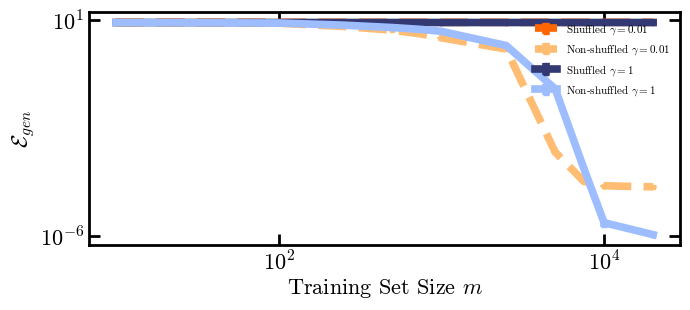

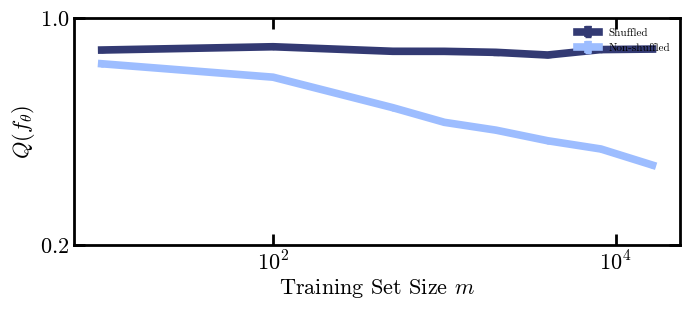

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

class SciencePlotter:
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (5.0, 5.0),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'xtick.labelsize': 16,    # Increased tick label font size
            'ytick.labelsize': 16,    # Increased tick label font size
            'axes.labelsize': 16,     # Increased axis label font size
            # Increased line widths
            'axes.linewidth': 2.0,  # Increased from 0.5
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            # Increased tick widths
            'xtick.major.width': 2.0,  # Increased from 0.5
            'ytick.major.width': 2.0,  # Increased from 0.5
            'xtick.minor.width': 1.5,  # Increased from 0.5
            'ytick.minor.width': 1.5,  # Increased from 0.5
            # Increased tick lengths
            'xtick.major.size': 8.0,   # Increased from 3
            'ytick.major.size': 8.0,   # Increased from 3
            'xtick.minor.size': 4.0,   # Increased from 1.5
            'ytick.minor.size': 4.0,   # Increased from 1.5
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 1.5,     # Increased from 0.5
            'lines.linewidth': 5.0,    # Set to match your request
            'lines.markersize': 8.0,   # Increased from 3
            # Removed legend parameters since we're not using legends
        })

    def configure_axes(self, ax, plot_type='gamma'):
        """Configure axes with exactly two ticks on each axis"""
        ax.set_xscale('log')
        
        # Set two x-ticks at powers of 10
        x_ticks = np.array([10**2, 10**4])
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'$10^{int(np.log10(x))}$' for x in x_ticks])
        
        if plot_type == 'gamma':
            ax.set_yscale('log')
            y_ticks = np.array([1e-6, 10])
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(['$10^{-6}$', '$10^{1}$'])
        else:
            ax.set_yscale('linear')
            y_ticks = np.array([0.2, 1.0])
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(['$0.2$', '$1.0$'])
            ax.set_ylim(0.2, 1.0)
        
        # Remove minor ticks
        ax.minorticks_off()
        
        # Update tick parameters to match the thicker lines
        ax.tick_params(which='major', direction='in', width=2.0, length=8.0)

def create_separate_plots(processed_data_gamma, processed_data_shuffle):
    """Create two separate plots with specified y-scales"""
    plotter = SciencePlotter()
    
    # Create figures
    fig1, ax1 = plt.subplots(figsize=(7.0, 3.2))
    fig2, ax2 = plt.subplots(figsize=(7.0, 3.2))
    
    # Styles for plots (removed labels since we're removing legends)
    styles_gamma = {
        'shuffled_gamma001': {
            'color': "#FF6500",
            'linestyle': '--',
            'linewidth': 5.0,
            'marker': 's',
            'markersize': 8.0
        },
        'non_shuffled_gamma001': {
            'color': "#FFBD73",
            'linestyle': '--',
            'linewidth': 5.0,
            'marker': 's',
            'markersize': 8.0
        },
        'shuffled_gamma01': {
            'color': "#333A73",
            'linestyle': '-',
            'linewidth': 5.0,
            'marker': 'o',
            'markersize': 8.0
        },
        'non_shuffled_gamma01': {
            'color': "#9DBDFF",
            'linestyle': '-',
            'linewidth': 5.0,
            'marker': 'o',
            'markersize': 8.0
        }
    }
    
    styles_shuffle = {
        'shuffled': {
            'color': "#333A73",
            'linestyle': '-',
            'linewidth': 5.0,
            'marker': 'o',
            'markersize': 8.0
        },
        'non_shuffled': {
            'color': "#9DBDFF",
            'linestyle': '-',
            'linewidth': 5.0,
            'marker': 'o',
            'markersize': 8.0
        }
    }

    def configure_axes(self, ax, plot_type='gamma'):
        """Configure axes with exactly two ticks on each axis"""
        ax.set_xscale('log')
        
        # Set two x-ticks at powers of 10
        x_ticks = np.array([10**2, 10**4])
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([f'$10^{int(np.log10(x))}$' for x in x_ticks])
        
        if plot_type == 'gamma':
            # First plot: log scale from 10^-6 to 10^0
            ax.set_yscale('log')
            y_ticks = np.array([1e-6, 10])
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(['$10^{-6}$', '$10^{1}$'])
            #ax.set_ylim(1e-6, 1e0)
        else:
            # Second plot: linear scale from 0.2 to 1.0
            ax.set_yscale('linear')
            y_ticks = np.array([0.2, 1.0])
            ax.set_yticks(y_ticks)
            ax.set_yticklabels(['$0.2$', '$1.0$'])
            ax.set_ylim(0.2, 1.0)
        
        # Remove minor ticks
        ax.minorticks_off()
        
        # Keep the tick parameters
        ax.tick_params(which='major', direction='in')

def load_results_gamma(paths_dict: Dict[str, List[str]], hidden_size: int) -> Dict:
    """Load results from gamma comparison JSON files."""
    all_data = {category: {'n_train': [], 'test_error': []} for category in paths_dict.keys()}
    
    for category, paths in paths_dict.items():
        for path in paths:
            with open(path, 'r') as f:
                data = json.load(f)
                for result in data:
                    if result.get('hidden_size', hidden_size) == hidden_size:
                        all_data[category]['n_train'].append(result['n_train'])
                        all_data[category]['test_error'].append(result['test_error'])
    
    return all_data

def load_results_shuffle(shuffled_paths: List[str], non_shuffled_paths: List[str]) -> Dict:
    """Load results from shuffle comparison JSON files."""
    all_data = {
        'shuffled': {'n_train': [], 'test_error': []},
        'non_shuffled': {'n_train': [], 'test_error': []}
    }
    
    for path in shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                all_data['shuffled']['n_train'].append(result['n_train'])
                all_data['shuffled']['test_error'].append(1.0 - result['best_test_accuracy'])
    
    for path in non_shuffled_paths:
        with open(path, 'r') as f:
            data = json.load(f)
            for result in data:
                all_data['non_shuffled']['n_train'].append(result['n_train'])
                all_data['non_shuffled']['test_error'].append(1.0 - result['best_test_accuracy'])
    
    return all_data

def process_data(data: Dict) -> Dict:
    """Calculate mean and standard error for each n_train value."""
    processed = {}
    
    for category in data.keys():
        n_train_values = sorted(list(set(data[category]['n_train'])))
        error_means = []
        error_sems = []
        
        for n in n_train_values:
            indices = [i for i, x in enumerate(data[category]['n_train']) if x == n]
            error_values = [data[category]['test_error'][i] for i in indices]
            error_means.append(np.mean(error_values))
            error_sems.append(np.std(error_values) / np.sqrt(len(error_values)))
        
        processed[category] = {
            'n_train': n_train_values,
            'error_mean': error_means,
            'error_sem': error_sems
        }
    
    return processed

def create_separate_plots(processed_data_gamma, processed_data_shuffle):
    """Create two separate plots with specified y-scales"""
    plotter = SciencePlotter()
    
    # Create figures
    fig1, ax1 = plt.subplots(figsize=(7.0, 3.2))
    fig2, ax2 = plt.subplots(figsize=(7.0, 3.2))
    
    # Styles for plots
    styles_gamma = {
        'shuffled_gamma001': PlotStyle(
            color="#FF6500",
            linestyle='--',
            linewidth=5.5,
            marker='s',
            markersize=3.0,
            label=r"Shuffled $\gamma=0.01$"
        ),
        'non_shuffled_gamma001': PlotStyle(
            color="#FFBD73",
            linestyle='--',
            linewidth=5.5,
            marker='s',
            markersize=3.5,
            label=r"Non-shuffled $\gamma=0.01$"
        ),
        'shuffled_gamma01': PlotStyle(
            color="#333A73",
            linestyle='-',
            linewidth=5.5,
            marker='o',
            markersize=3.0,
            label=r"Shuffled $\gamma=1$"
        ),
        'non_shuffled_gamma01': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=5.5,
            marker='o',
            markersize=3.5,
            label=r"Non-shuffled $\gamma=1$"
        )
    }
    
    styles_shuffle = {
        'shuffled': PlotStyle(
            color="#333A73",
            linestyle='-',
            linewidth=5.5,
            marker='o',
            markersize=3.0,
            label="Shuffled"
        ),
        'non_shuffled': PlotStyle(
            color="#9DBDFF",
            linestyle='-',
            linewidth=5.5,
            marker='o',
            markersize=3.5,
            label="Non-shuffled"
        )
    }
    
    # Plot gamma comparison
    for category, style in styles_gamma.items():
        data = processed_data_gamma[category]
        ax1.errorbar(data['n_train'], data['error_mean'],
                    yerr=data['error_sem'],
                    color=style.color,
                    linestyle=style.linestyle,
                    linewidth=style.linewidth,
                    marker=style.marker,
                    markersize=style.markersize,
                    label=style.label,
                    capsize=2)
    
    # Plot shuffle comparison
    for category, style in styles_shuffle.items():
        data = processed_data_shuffle[category]
        ax2.errorbar(data['n_train'], data['error_mean'],
                    yerr=data['error_sem'],
                    color=style.color,
                    linestyle=style.linestyle,
                    linewidth=style.linewidth,
                    marker=style.marker,
                    markersize=style.markersize,
                    label=style.label,
                    capsize=2)
    
    # Configure axes with different scales
    plotter.configure_axes(ax1, plot_type='gamma')
    plotter.configure_axes(ax2, plot_type='shuffle')
    
    # Set labels
    ax1.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax1.set_ylabel(r'$\mathcal{E}_{gen}$', labelpad=2)
    ax2.set_xlabel(r'Training Set Size $m$', labelpad=2)
    ax2.set_ylabel(r'$Q(f_{\mathbf{\theta}})$', labelpad=2)
    
    # Add legends
    ax1.legend(loc='upper right', fontsize=8, frameon=False)
    ax2.legend(loc='upper right', fontsize=8, frameon=False)
    
    # Adjust layouts
    fig1.tight_layout()
    fig2.tight_layout()
    
    return fig1, fig2

def main():
    try:
        # Data loading for gamma comparison
        hidden_size = 1000
        paths_dict = {
            'shuffled_gamma001': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_1/results_20250120_214844_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_2/results_20250120_230631_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/results_20250121_001615_rank0.json",
            ],
            'non_shuffled_gamma001': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/results_20250120_214901_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_2/results_20250120_231122_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_3/results_20250121_002630_rank0.json",
            ],
            'shuffled_gamma01': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json"
            ],
            'non_shuffled_gamma01': [
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
                "/mnt/users/goringn/NNs_vs_Kernels/NTK/results/jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json"
            ]
        }
        
        # Data loading for shuffle comparison
        shuffled_paths = [
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_1.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_2.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/shuffle_3.json"
        ]
        
        non_shuffled_paths = [
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle1.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle2.json",
            "/mnt/users/goringn/NNs_vs_Kernels/figures/math_copy/no_shuffle_3.json"
        ]
        
        # Process both sets of data
        raw_data_gamma = load_results_gamma(paths_dict, hidden_size)
        processed_data_gamma = process_data(raw_data_gamma)
        
        raw_data_shuffle = load_results_shuffle(shuffled_paths, non_shuffled_paths)
        processed_data_shuffle = process_data(raw_data_shuffle)
        
        # Create and save plots
        fig_gamma, fig_shuffle = create_separate_plots(processed_data_gamma, processed_data_shuffle)
        
        # Save plots
        fig_gamma.savefig('gamma_test_error_comparison1.png',
                         dpi=300,
                         bbox_inches='tight',
                         facecolor='white',
                         edgecolor='black')
        
        fig_gamma.savefig('gamma_test_error_comparison.svg',
                         bbox_inches='tight',
                         facecolor='white',
                         edgecolor='black')
        
        fig_shuffle.savefig('shuffle_test_error_comparison2.png',
                          dpi=300,
                          bbox_inches='tight',
                          facecolor='white',
                          edgecolor='black')
        
        fig_shuffle.savefig('gamma_test_error_comparison2.svg',
                          bbox_inches='tight',
                          facecolor='white',
                          edgecolor='black')
        
        plt.show()
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file: {e.filename}")
        print("Please check if the file paths are correct")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

In [8]:
import numpy as np
import json
from typing import Dict, List, NamedTuple
from dataclasses import dataclass

@dataclass
class ExperimentData:
    n_train: np.ndarray  # training set sizes
    mean: np.ndarray     # mean values
    sem: np.ndarray      # standard error of mean values

@dataclass
class PlottingArrays:
    # Gamma comparison data (test error)
    shuffled_gamma001: ExperimentData    # Shuffled data with gamma=0.01
    nonshuffled_gamma001: ExperimentData # Non-shuffled data with gamma=0.01
    shuffled_gamma1: ExperimentData      # Shuffled data with gamma=1.0
    nonshuffled_gamma1: ExperimentData   # Non-shuffled data with gamma=1.0
    
    # Metrics comparison data (Q metrics)
    shuffled_q1: ExperimentData          # Shuffled Q1 metric (CKA)
    nonshuffled_q1: ExperimentData       # Non-shuffled Q1 metric (CKA)
    shuffled_q2: ExperimentData          # Shuffled Q2 metric (Frobenius)
    nonshuffled_q2: ExperimentData       # Non-shuffled Q2 metric (Frobenius)

def load_all_plotting_arrays(hidden_size: int = 1000) -> PlottingArrays:
    """
    Load and organize all arrays needed for plotting from the experimental data.
    
    Args:
        hidden_size: Neural network hidden layer size (default=1000)
    
    Returns:
        PlottingArrays object containing all organized data arrays
    """
    # Define file paths
    gamma_paths = {
        'shuffled_gamma001': [
            "jax_mspgpu_20k_h1000_lr0005_true_gamma001_1/results_20250120_214844_rank0.json",
            "jax_mspgpu_20k_h1000_lr0005_true_gamma001_2/results_20250120_230631_rank0.json",
            "jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/results_20250121_001615_rank0.json",
        ],
        'non_shuffled_gamma001': [
            "jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/results_20250120_214901_rank0.json",
            "jax_mspgpu_20k_h1000_lr0005_false_gamma001_2/results_20250120_231122_rank0.json",
            "jax_mspgpu_20k_h1000_lr0005_false_gamma001_3/results_20250121_002630_rank0.json",
        ],
        'shuffled_gamma1': [
            "jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
            "jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
            "jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json"
        ],
        'non_shuffled_gamma1': [
            "jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
            "jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
            "jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json"
        ]
    }
    
    metrics_paths = {
        'shuffled': [
            "math_copy/shuffle_1.json",
            "math_copy/shuffle_2.json",
            "math_copy/shuffle_3.json"
        ],
        'non_shuffled': [
            "math_copy/no_shuffle1.json",
            "math_copy/no_shuffle2.json",
            "math_copy/no_shuffle_3.json"
        ]
    }
    
    def process_experiment_data(data_dict: Dict) -> ExperimentData:
        """Helper function to process raw data into ExperimentData object"""
        n_train_values = sorted(list(set(data_dict['n_train'])))
        means = []
        sems = []
        
        for n in n_train_values:
            indices = [i for i, x in enumerate(data_dict['n_train']) if x == n]
            if 'test_error' in data_dict:
                values = [data_dict['test_error'][i] for i in indices]
            else:  # metrics data
                values = [data_dict['cka'][i] for i in indices]
            
            means.append(np.mean(values))
            sems.append(np.std(values) / np.sqrt(len(values)))
        
        return ExperimentData(
            n_train=np.array(n_train_values),
            mean=np.array(means),
            sem=np.array(sems)
        )
    
    # Load gamma comparison data
    gamma_data = {}
    for category, paths in gamma_paths.items():
        data_dict = {'n_train': [], 'test_error': []}
        for path in paths:
            with open(path, 'r') as f:
                data = json.load(f)
                for result in data:
                    if result.get('hidden_size', hidden_size) == hidden_size:
                        data_dict['n_train'].append(result['n_train'])
                        data_dict['test_error'].append(result['test_error'])
        gamma_data[category] = process_experiment_data(data_dict)
    
    # Load metrics comparison data
    metrics_data = {}
    for category, paths in metrics_paths.items():
        data_dict = {'n_train': [], 'cka': [], 'frob': []}
        for path in paths:
            with open(path, 'r') as f:
                data = json.load(f)
                for result in data:
                    data_dict['n_train'].append(result['n_train'])
                    data_dict['cka'].append(result['ntk_cka_init_vs_final'])
                    data_dict['frob'].append(result['ntk_frob_init_vs_final'])
        
        # Process CKA (Q1) and Frobenius (Q2) separately
        metrics_data[f'{category}_q1'] = process_experiment_data(
            {'n_train': data_dict['n_train'], 'cka': data_dict['cka']}
        )
        metrics_data[f'{category}_q2'] = process_experiment_data(
            {'n_train': data_dict['n_train'], 'cka': data_dict['frob']}
        )
    
    return PlottingArrays(
        # Gamma comparison data
        shuffled_gamma001=gamma_data['shuffled_gamma001'],
        nonshuffled_gamma001=gamma_data['non_shuffled_gamma001'],
        shuffled_gamma1=gamma_data['shuffled_gamma1'],
        nonshuffled_gamma1=gamma_data['non_shuffled_gamma1'],
        
        # Metrics comparison data
        shuffled_q1=metrics_data['shuffled_q1'],
        nonshuffled_q1=metrics_data['non_shuffled_q1'],
        shuffled_q2=metrics_data['shuffled_q2'],
        nonshuffled_q2=metrics_data['non_shuffled_q2']
    )

In [ ]:
######

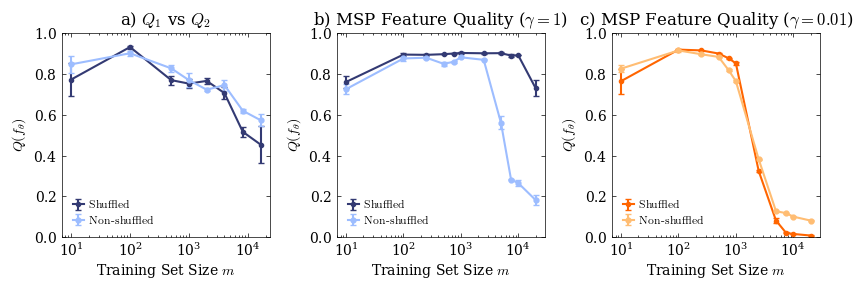

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Union
import json
import os

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    BLUE = '#333A73'
    LIGHT_BLUE = '#9DBDFF'
    ORANGE = '#FF6500'
    LIGHT_ORANGE = '#FFBD73'
    GREYBLACK = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['Computer Modern Roman', 'DejaVu Serif'],  # Changed font priority
            'text.usetex': True,  # Enable LaTeX rendering
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

def load_and_process_data(paths: List[str], base_dir: str, hidden_size: int = 1000) -> Dict:
    """Load and process data from multiple files."""
    data = {'n_train': [], 'cka': []}
    
    for path in paths:
        full_path = os.path.join(base_dir, path)
        try:
            with open(full_path, 'r') as f:
                file_data = json.load(f)
                for result in file_data:
                    if result.get('hidden_size', hidden_size) == hidden_size:
                        data['n_train'].append(result['n_train'])
                        if 'ntk_cka' in result:
                            data['cka'].append(result['ntk_cka'])
                        elif 'ntk_cka_init_vs_final' in result:
                            data['cka'].append(result['ntk_cka_init_vs_final'])
        except Exception as e:
            print(f"Error processing file {full_path}: {str(e)}")
            continue

    if not data['n_train']:
        print(f"Warning: No data loaded for paths: {paths}")
        return {'n_train': [], 'cka_mean': [], 'cka_sem': []}

    # Process the data
    n_train_values = sorted(list(set(data['n_train'])))
    cka_means = []
    cka_sems = []
    
    for n in n_train_values:
        indices = [i for i, x in enumerate(data['n_train']) if x == n]
        cka_values = [data['cka'][i] for i in indices]
        cka_means.append(np.mean(cka_values))
        cka_sems.append(np.std(cka_values) / np.sqrt(len(cka_values)))
    
    return {
        'n_train': n_train_values,
        'cka_mean': cka_means,
        'cka_sem': cka_sems
    }

def create_combined_plot(metrics_data, gamma1_data, gamma001_data):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8.4, 3.0))
    plotter = SciencePlotter()

    # Common style settings
    styles = {
        'metrics': {
            'shuffled': PlotStyle(
                color=plotter.BLUE,
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=3.0,
                label="Shuffled"
            ),
            'non_shuffled': PlotStyle(
                color=plotter.LIGHT_BLUE,
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=3.5,
                label="Non-shuffled"
            )
        },
        'gamma1': {
            'shuffled': PlotStyle(
                color=plotter.BLUE,
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=3.0,
                label="Shuffled"
            ),
            'non_shuffled': PlotStyle(
                color=plotter.LIGHT_BLUE,
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=3.5,
                label="Non-shuffled"
            )
        },
        'gamma001': {
            'shuffled': PlotStyle(
                color=plotter.ORANGE,
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=3.0,
                label="Shuffled"
            ),
            'non_shuffled': PlotStyle(
                color=plotter.LIGHT_ORANGE,
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=3.5,
                label="Non-shuffled"
            )
        }
    }

    # Plot data for each panel
    data_configs = [
        (ax1, metrics_data, styles['metrics'], r'a) $Q_1$ vs $Q_2$'),
        (ax2, gamma1_data, styles['gamma1'], r'b) MSP Feature Quality ($\gamma=1$)'),
        (ax3, gamma001_data, styles['gamma001'], r'c) MSP Feature Quality ($\gamma=0.01$)')
    ]

    for ax, data, style_dict, title in data_configs:
        for category, style in style_dict.items():
            if category in data and data[category]['n_train']:
                ax.errorbar(data[category]['n_train'], 
                          data[category]['cka_mean'],
                          yerr=data[category]['cka_sem'],
                          color=style.color,
                          linestyle=style.linestyle,
                          linewidth=style.linewidth,
                          marker=style.marker,
                          markersize=style.markersize,
                          label=style.label,
                          capsize=2)

        ax.set_xscale('log')
        ax.set_xlabel(r'Training Set Size $m$', labelpad=2)
        ax.set_ylabel(r'$Q(f_{\mathbf{\theta}})$')
        ax.set_ylim(0, 1)
        ax.set_title(title)
        if len(data) > 0:  # Only add legend if there's data
            ax.legend(frameon=False, loc='lower left', fontsize=8)

    plt.tight_layout()
    return fig

def main():
    # Base directory for data files
    base_dir = "/mnt/users/goringn/NNs_vs_Kernels"
    
    # Define relative paths
    gamma_paths = {
        'shuffled_gamma001': [
            "NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_1/results_20250120_214844_rank0.json",
            "NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_2/results_20250120_230631_rank0.json",
            "NTK/results/jax_mspgpu_20k_h1000_lr0005_true_gamma001_3/results_20250121_001615_rank0.json"
        ],
        'non_shuffled_gamma001': [
            "NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_1/results_20250120_214901_rank0.json",
            "NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_2/results_20250120_231122_rank0.json",
            "NTK/results/jax_mspgpu_20k_h1000_lr0005_false_gamma001_3/results_20250121_002630_rank0.json"
        ],
        'shuffled_gamma1': [
            "NTK/results/jax_mspgpu_h1000_lr0005_true_1/results_20250119_183916_rank0.json",
            "NTK/results/jax_mspgpu_h1000_lr0005_true_2/results_20250119_195244_rank0.json",
            "NTK/results/jax_mspgpu_h1000_lr0005_true_3/results_20250119_205928_rank0.json"
        ],
        'non_shuffled_gamma1': [
            "NTK/results/jax_mspgpu_h1000_lr0005_false_1/results_20250119_183429_rank0.json",
            "NTK/results/jax_mspgpu_h1000_lr0005_false_2/results_20250119_193956_rank0.json",
            "NTK/results/jax_mspgpu_h1000_lr0005_false_3/results_20250119_203730_rank0.json"
        ]
    }

    metrics_paths = {
        'shuffled': [
            "figures/math_copy/shuffle_1.json",
            "figures/math_copy/shuffle_2.json",
            "figures/math_copy/shuffle_3.json"
        ],
        'non_shuffled': [
            "figures/math_copy/no_shuffle1.json",
            "figures/math_copy/no_shuffle2.json",
            "figures/math_copy/no_shuffle_3.json"
        ]
    }

    # Load and process all data
    metrics_data = {
        'shuffled': load_and_process_data(metrics_paths['shuffled'], base_dir),
        'non_shuffled': load_and_process_data(metrics_paths['non_shuffled'], base_dir)
    }

    gamma1_data = {
        'shuffled': load_and_process_data(gamma_paths['shuffled_gamma1'], base_dir),
        'non_shuffled': load_and_process_data(gamma_paths['non_shuffled_gamma1'], base_dir)
    }

    gamma001_data = {
        'shuffled': load_and_process_data(gamma_paths['shuffled_gamma001'], base_dir),
        'non_shuffled': load_and_process_data(gamma_paths['non_shuffled_gamma001'], base_dir)
    }

    # Create and save the plot
    fig = create_combined_plot(metrics_data, gamma1_data, gamma001_data)
    
    # Save as PNG and SVG
    fig.savefig('combined_quality_plots.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

    fig.savefig('combined_quality_plots.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

    plt.show()

if __name__ == "__main__":
    main()